In [245]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [246]:
import pandas as pd
import geopandas as gpd
import xgboost
import sys
from sklearn.preprocessing import LabelEncoder
import numpy as np
from math import * 
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.cluster import DBSCAN, OPTICS
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures

import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.style.use('dark_background')

from utils import plot_cluster, load_list, save_list, load_data, load_data_test


In [279]:
X, Y = load_data(add_knn_mean=True,
                 add_knn_concat=False,
                 add_polynomial=False,
                 n_data_max=9999999999,
                 shuffle = False)

# X_target = load_data_test(add_knn_mean=True,
#                  add_knn_concat=False,
#                  n_data_max=99999999,
#                  shuffle = False)

print(f'Datas containing NA loaded: {len(X[X.isna().any(axis = 1)])}')


Loading data...
X_train and Y_train loaded.
Datas containing NA loaded: 0


In [281]:
print(X.shape)
print(Y.shape)

(309736, 93)
(309736,)


In [282]:

# xgb = XGBClassifier()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 22)

print('Fitting...')
L_n = [2, 5, 10, 20, 50, 100, 200, 400]
L_d = [2, 3, 4, 5, 10]
average = 'weighted'
L_train_score = list()
L_test_score = list()
L = list()

for n in L_n:
        model = RandomForestClassifier(n_estimators=n,
                            max_depth=15,
                            min_samples_leaf=1,
                            min_samples_split=2,
                                )
        # model = GradientBoostingClassifier(n_estimators=n, 
        #                         )
        # model = XGBClassifier( 
        #                 n_estimators = n,
        #         #       scale_pos_weight=1,
        #         #       learning_rate=0.01,  
        #         #       colsample_bytree = 0.4,
        #         #       subsample = 0.8,
        #         #       objective='binary:logistic', 
        #         #       reg_alpha = 0.3,
        #         #       max_depth=4, 
        #         #       gamma=10,
        #                 use_label_encoder=False,
        #               )
        
        eval_set = [(X_train, Y_train), (X_test, Y_test)]
        eval_metric = ["error"]
        model.fit(X_train, Y_train, 
                # eval_metric=eval_metric, 
                # eval_set=eval_set, 
                # verbose=False
                  )
        
        Y_pred          = model.predict(X_test)
        Y_pred_train    = model.predict(X_train)
        score_train = f1_score(Y_train, Y_pred_train, average = average)
        score_test = f1_score(Y_test, Y_pred, average = average)
        L_train_score.append(score_train)
        L_test_score.append(score_test)
        L.append(n)
        print(f"Train score: {score_train}")
        print(f"Test score: {score_test}")
        print()
        plt.clf()
        plt.plot(L, L_train_score, 'r')
        plt.plot(L, L_test_score, 'b')
        plt.ylim(bottom = 0, top = 1)



Fitting...
Train score: 0.7851846531411517
Test score: 0.7107621310961637

Train score: 0.8153188278207226
Test score: 0.7450656541308742

Train score: 0.8278571140854215
Test score: 0.757269096064369

Train score: 0.8356031364996643
Test score: 0.7631176955160505



In [271]:
importances = model.feature_importances_
for feature, imp in sorted(zip(X_train.columns, importances), key = lambda x: -x[1]):
    print(f'Importance of {feature}: {100*round(imp, 3)}%')

Importance of change_status_date5: 8.1%
Importance of centroid_x: 7.9%
Importance of knn_mean_centroid_x: 6.800000000000001%
Importance of knn_mean_elongation: 5.0%
Importance of centroid_y: 4.9%
Importance of change_status_date1: 4.8%
Importance of knn_mean_centroid_dist: 4.5%
Importance of knn_mean_area/length**2: 3.8%
Importance of knn_mean_height: 3.5000000000000004%
Importance of knn_mean_length: 3.3000000000000003%
Importance of change_status_date2: 3.3000000000000003%
Importance of centroid_dist: 3.2%
Importance of area/length**2: 3.1%
Importance of knn_mean_length/width: 2.9000000000000004%
Importance of knn_mean_width: 2.8000000000000003%
Importance of length: 2.5%
Importance of change_status_date4: 2.3%
Importance of height: 2.1%
Importance of width: 1.7999999999999998%
Importance of Unnamed: 0: 1.7999999999999998%
Importance of change_status_date3: 1.6%
Importance of knn_mean_diff2: 1.6%
Importance of elongation: 1.4000000000000001%
Importance of diff2: 1.4000000000000001%
I

In [15]:
Y_pred2submit = model.predict(X_target)

# Save results to submission file
pred_df = pd.DataFrame(Y_pred2submit, columns=['change_type'])
pred_df.to_csv("submission.csv", index=True, index_label='Id')

In [33]:
test_df_origin = gpd.read_file("test.geojson", index_col=0) 

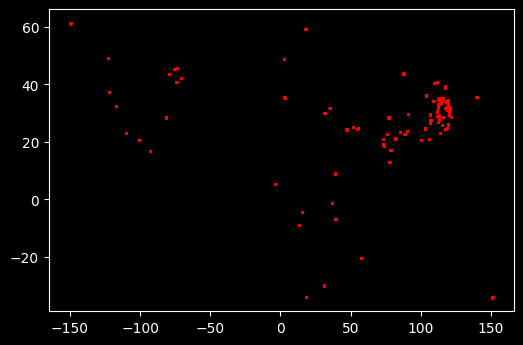

In [119]:
plot_cluster(X)

In [118]:
def compress_outliers_on_test(X):
    X[46053:47903]['centroid_y'] = (X[46053:47903]['centroid_y'] - 60) / (60/0.03) + 30
    return X